In [4]:
import warnings
warnings.filterwarnings("ignore")
import torch
import numpy as np
import os
import matplotlib.pyplot as plt 
import pickle

from einops import rearrange

from models.tfm_token import get_tfm_tokenizer_2x2x8
from utils.utils import  get_stft_torch, plot_token_interpret_tuev

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Token Visualization Example

In [5]:
tokenizer_path = './pretrained_weigths/TUEV_tfm_tokenizer_2x2x8/tfm_tokenizer_last.pth'

tokenizer = get_tfm_tokenizer_2x2x8(code_book_size=8192, emb_size=64)
tokenizer.load_state_dict(torch.load(tokenizer_path), strict=False)
tokenizer.to(device)
tokenizer.eval()


TFM_VQVAE2_deep(
  (freq_patch_embedding): Sequential(
    (0): Conv1d(1, 64, kernel_size=(5,), stride=(5,))
    (1): GELU(approximate='none')
    (2): GroupNorm(16, 64, eps=1e-05, affine=True)
    (3): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (4): GELU(approximate='none')
    (5): GroupNorm(16, 64, eps=1e-05, affine=True)
    (6): Conv1d(64, 64, kernel_size=(1,), stride=(1,))
    (7): GELU(approximate='none')
    (8): GroupNorm(16, 64, eps=1e-05, affine=True)
  )
  (trans_freq_encoder): TransformerEncoder(
    (transformer): LinearAttentionTransformer(
      (layers): SequentialSequence(
        (layers): ModuleList(
          (0-1): 2 x ModuleList(
            (0): PreNorm(
              (fn): SelfAttention(
                (local_attn): LocalAttention(
                  (dropout): Dropout(p=0.2, inplace=False)
                )
                (to_q): Linear(in_features=64, out_features=64, bias=False)
                (to_k): Linear(in_features=64, out_features=64, bias=Fal

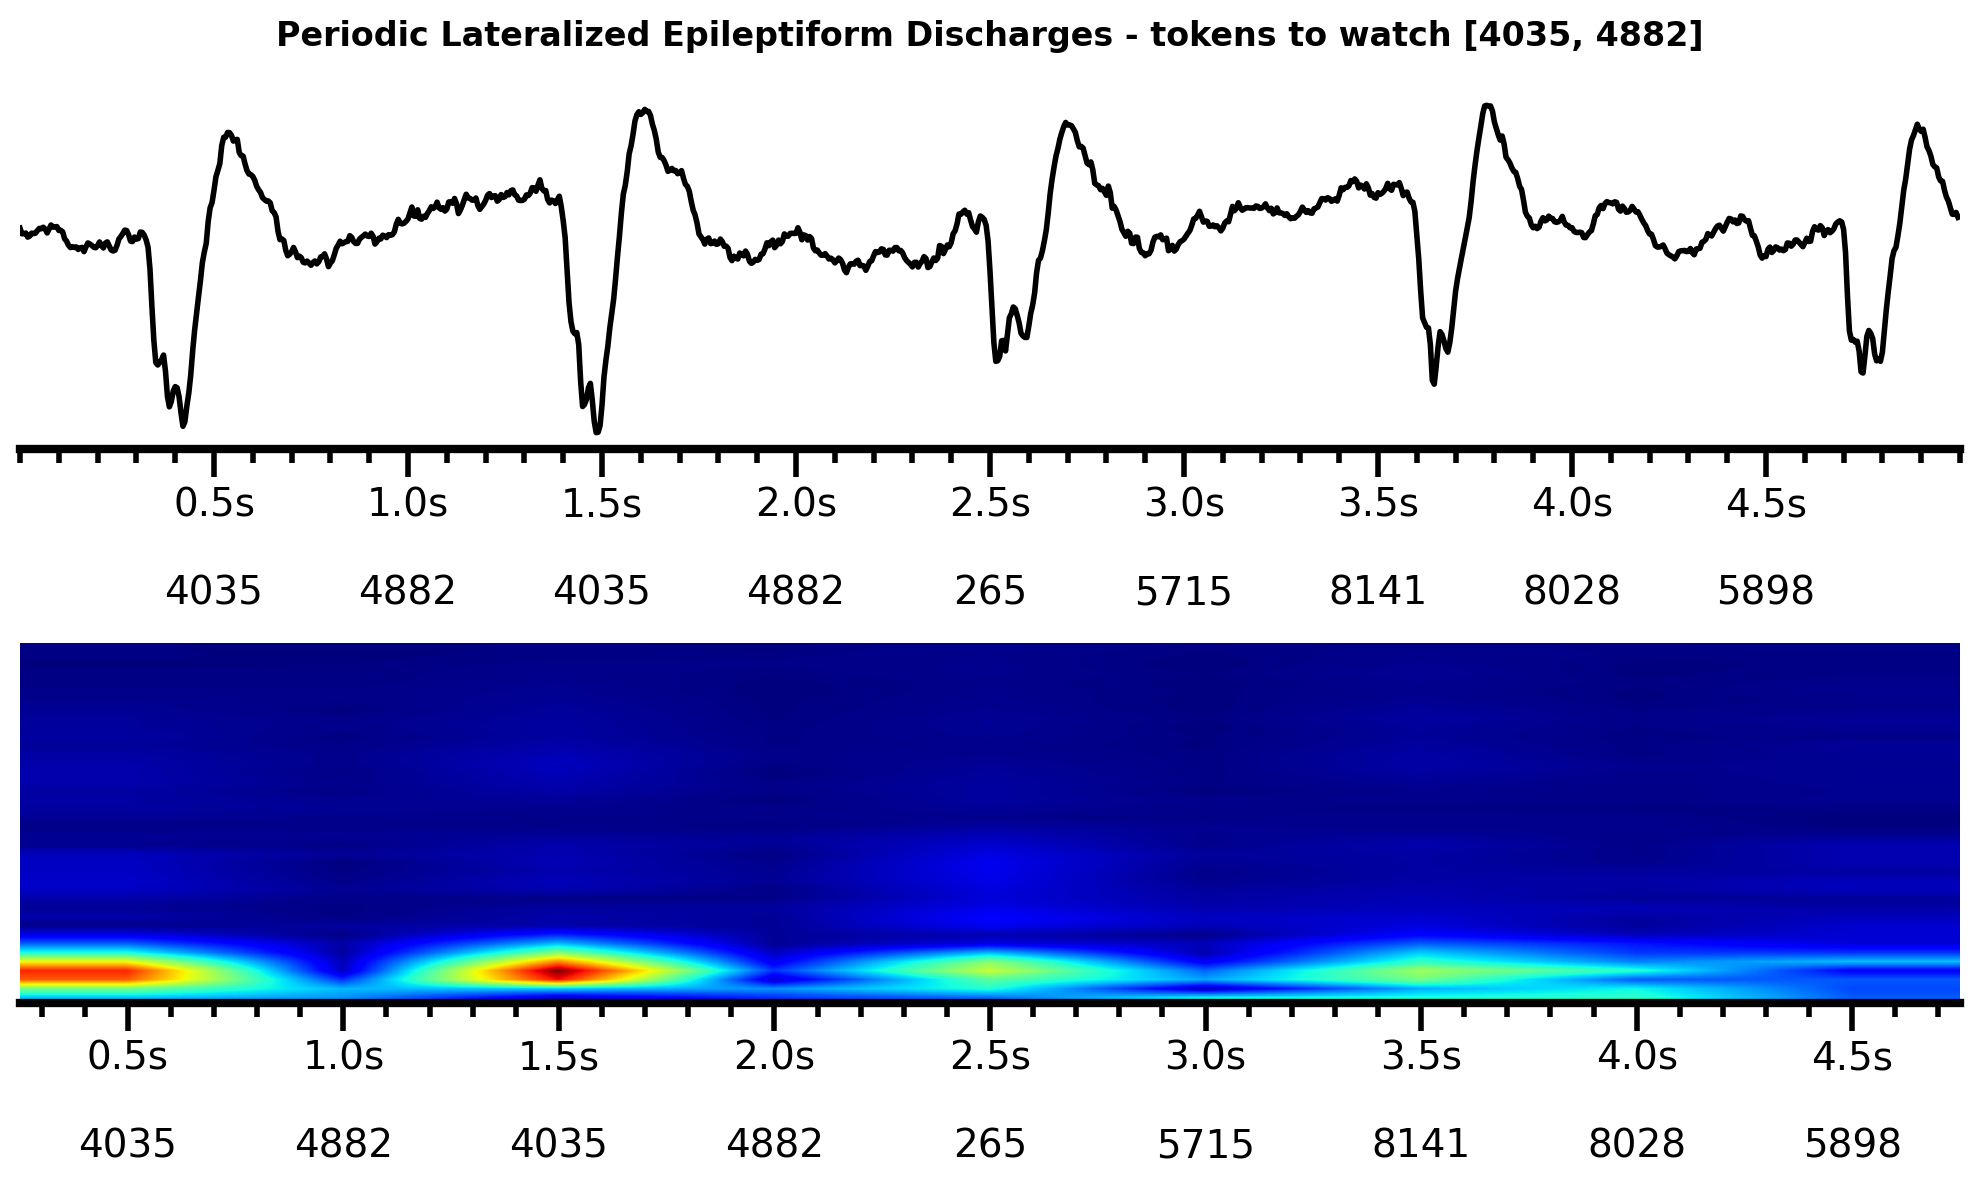

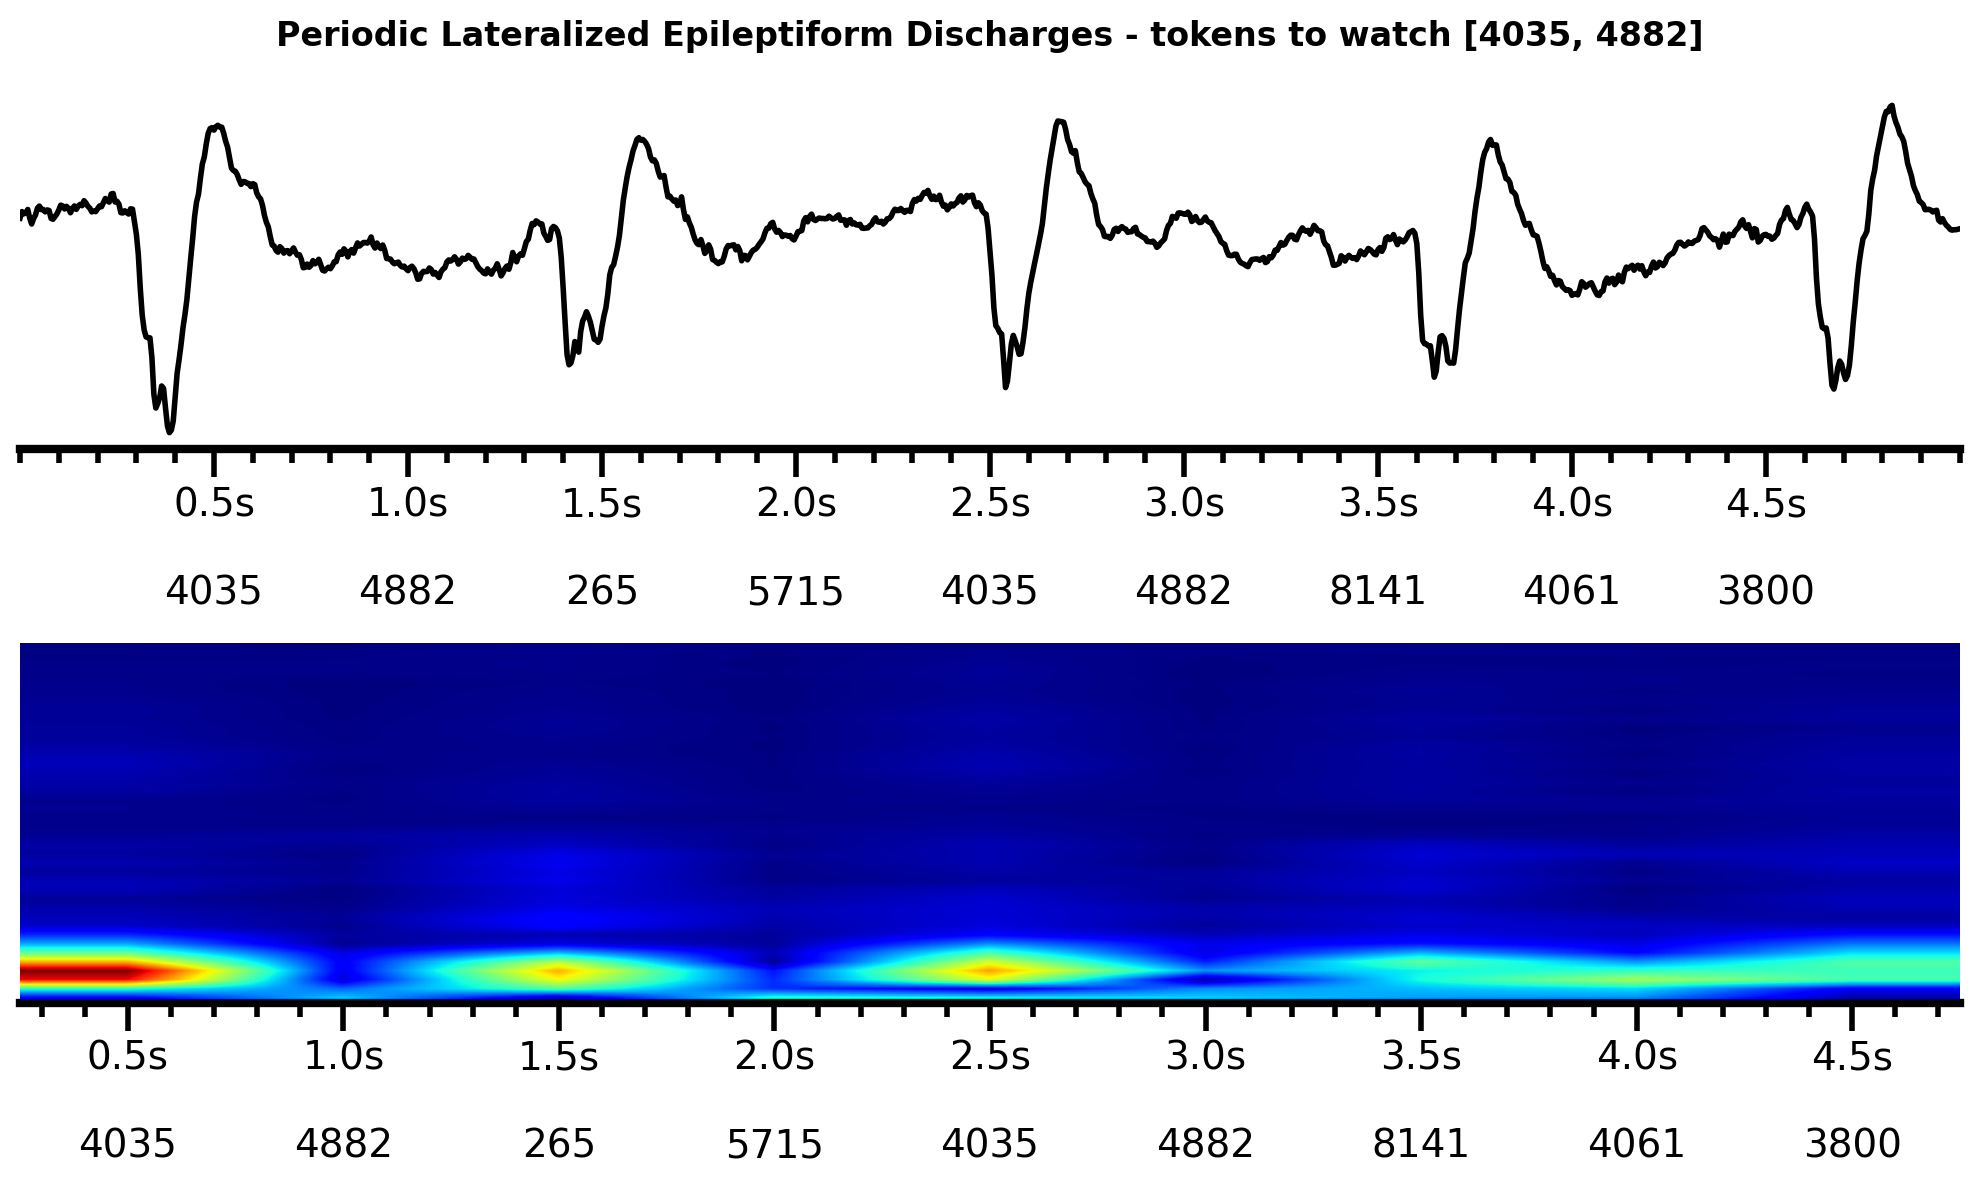

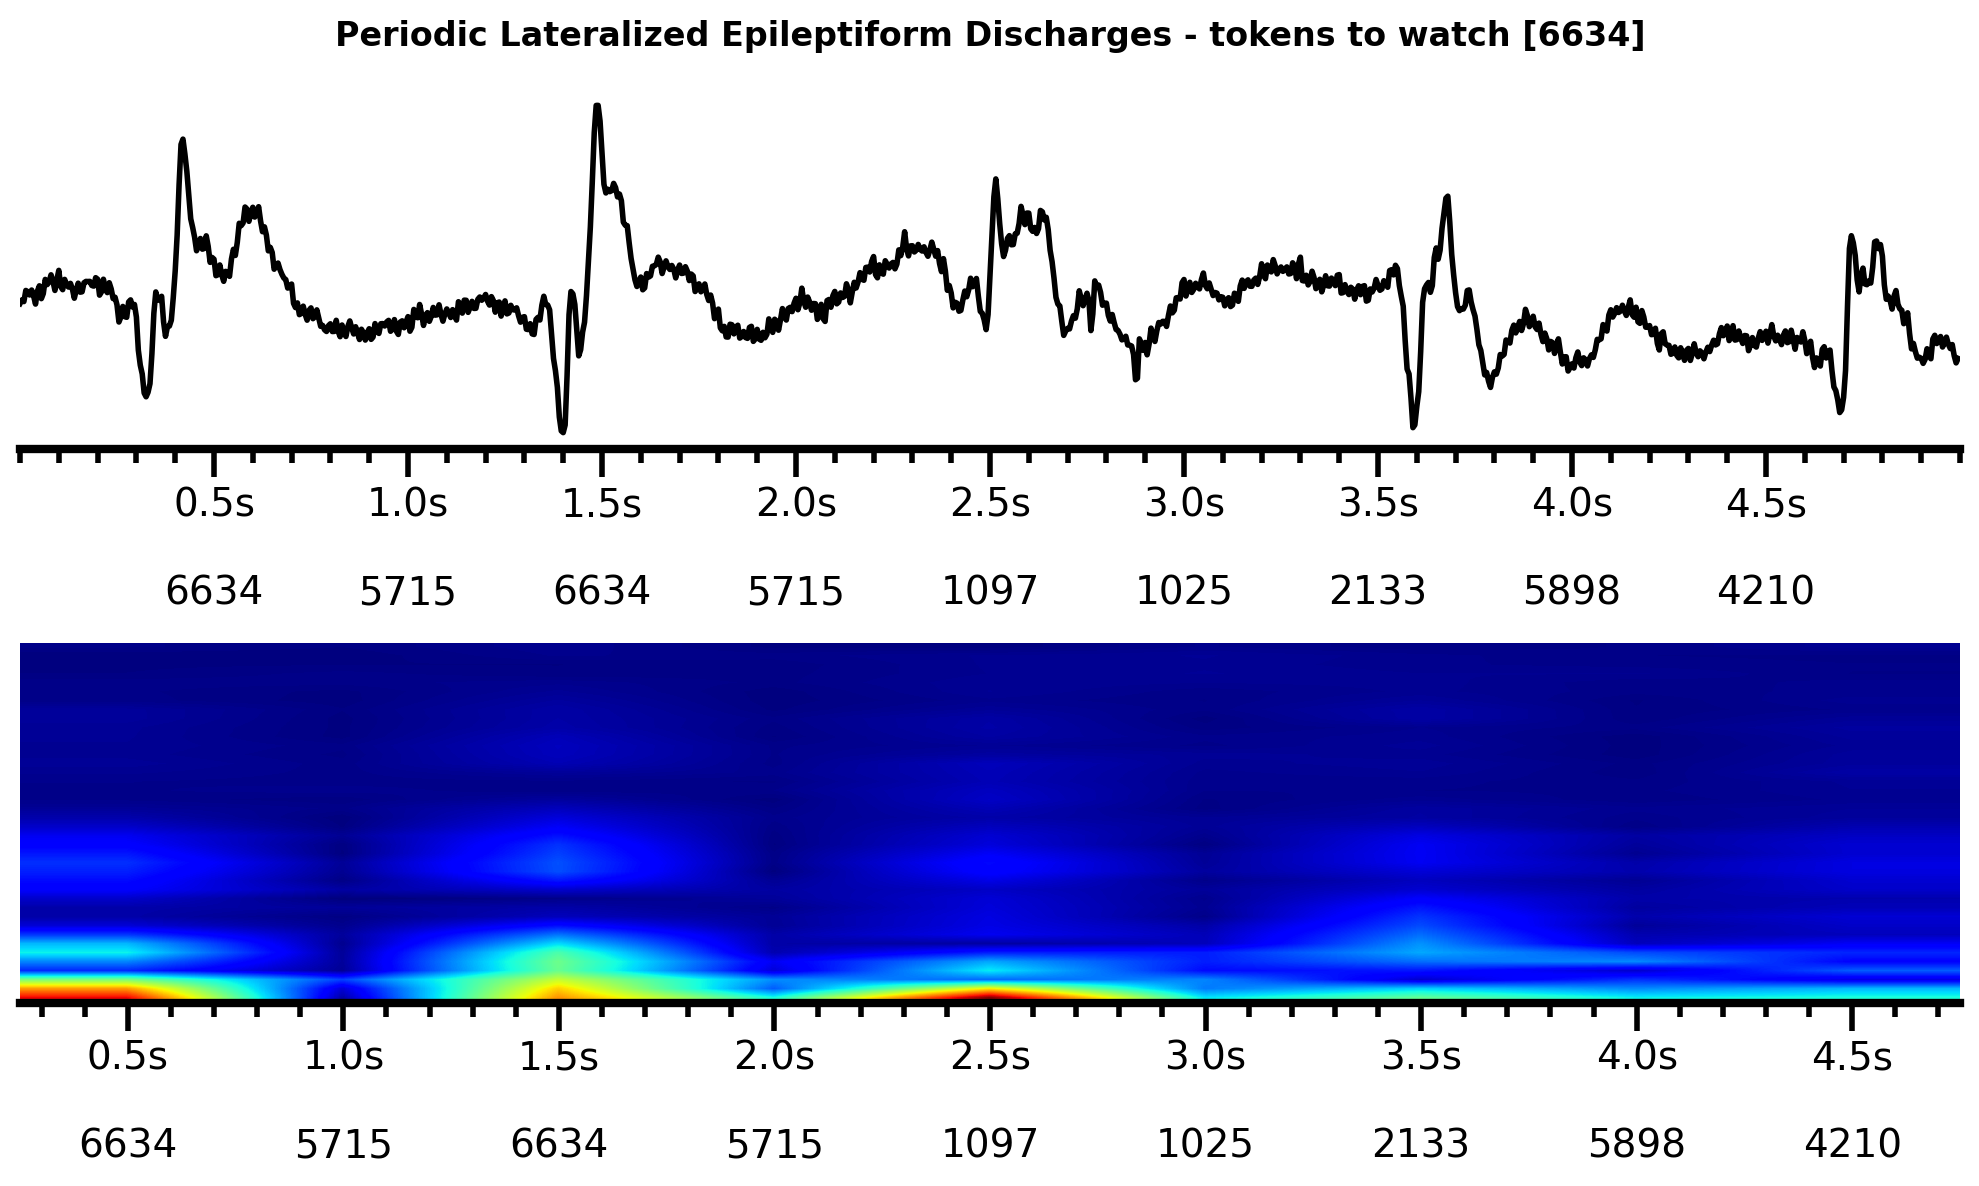

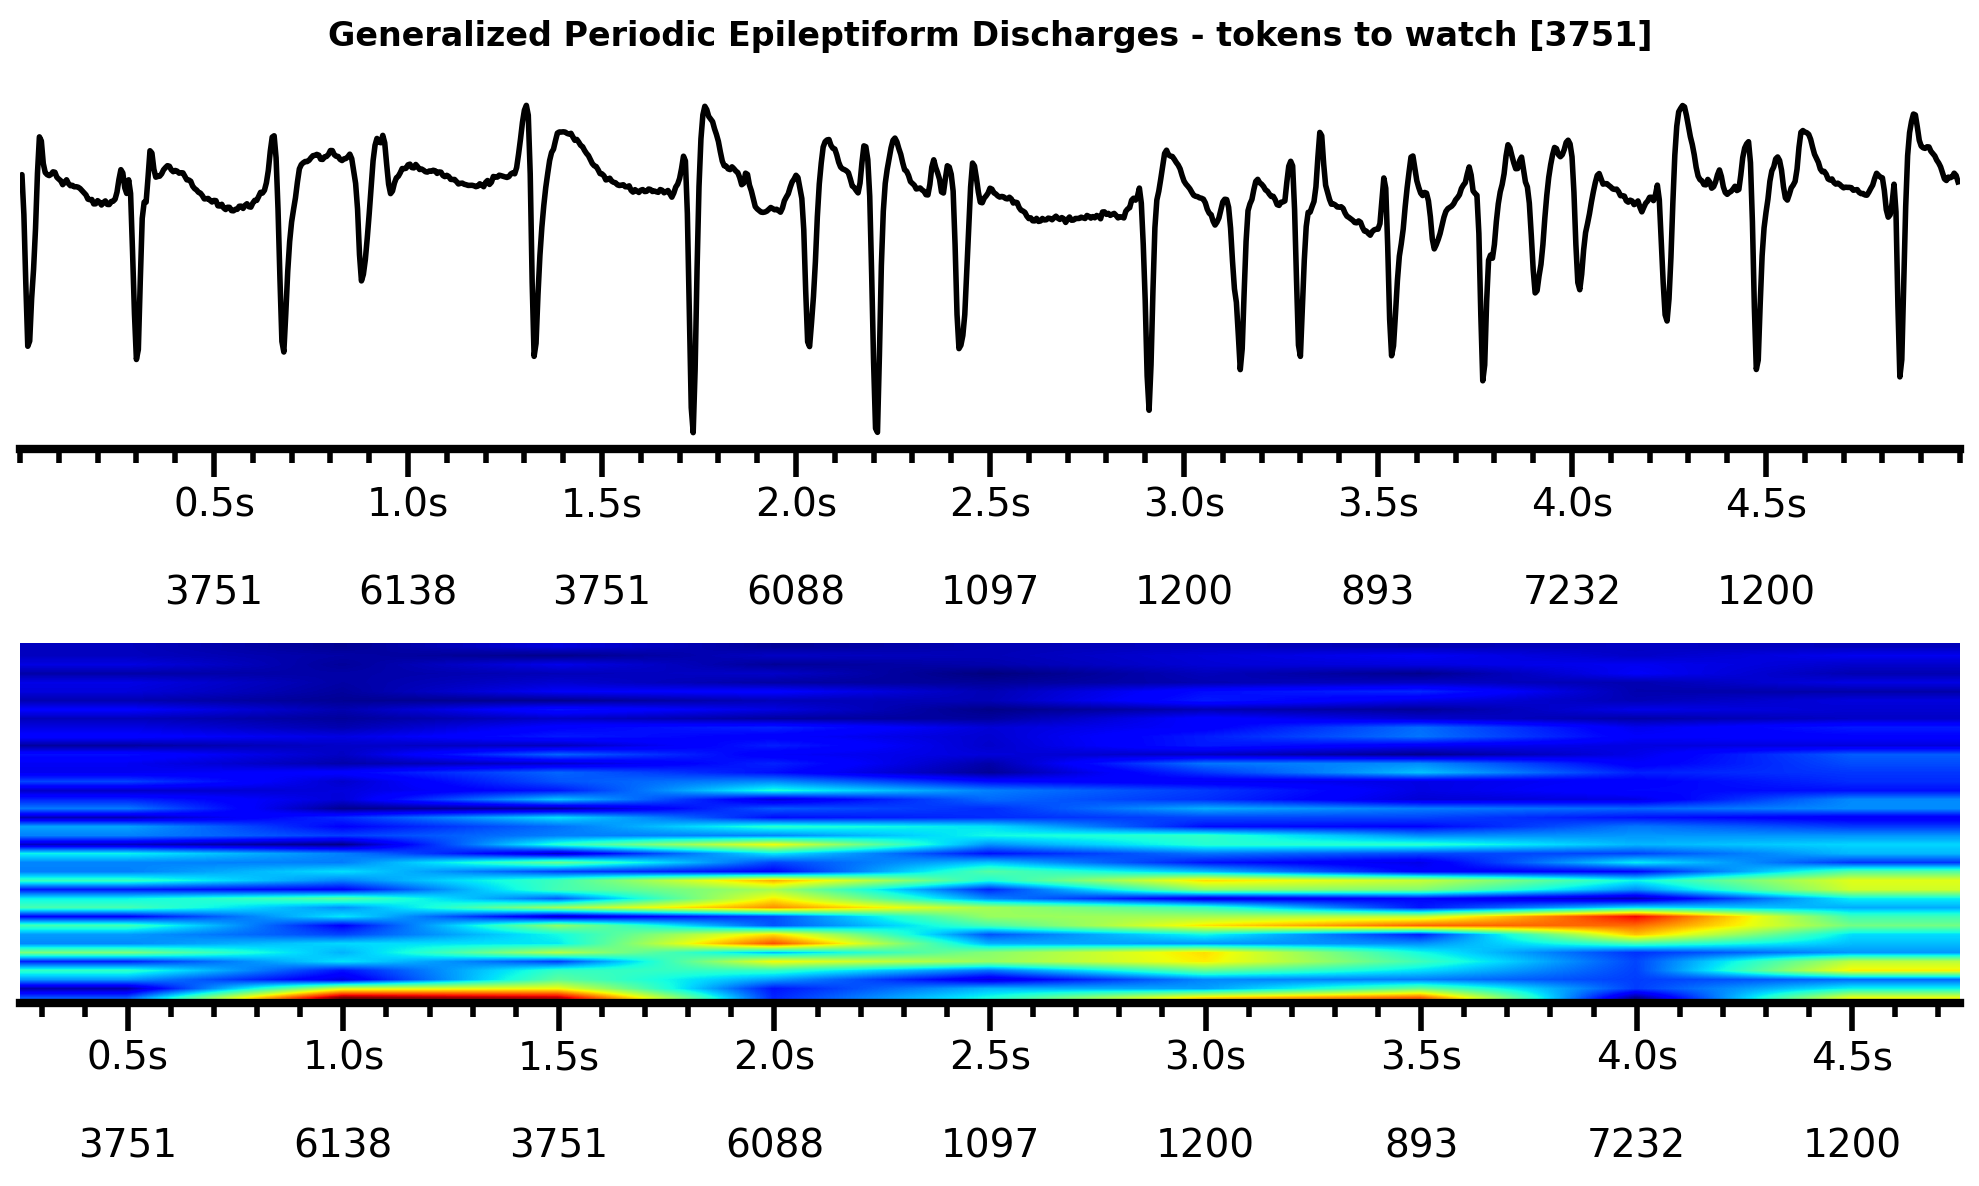

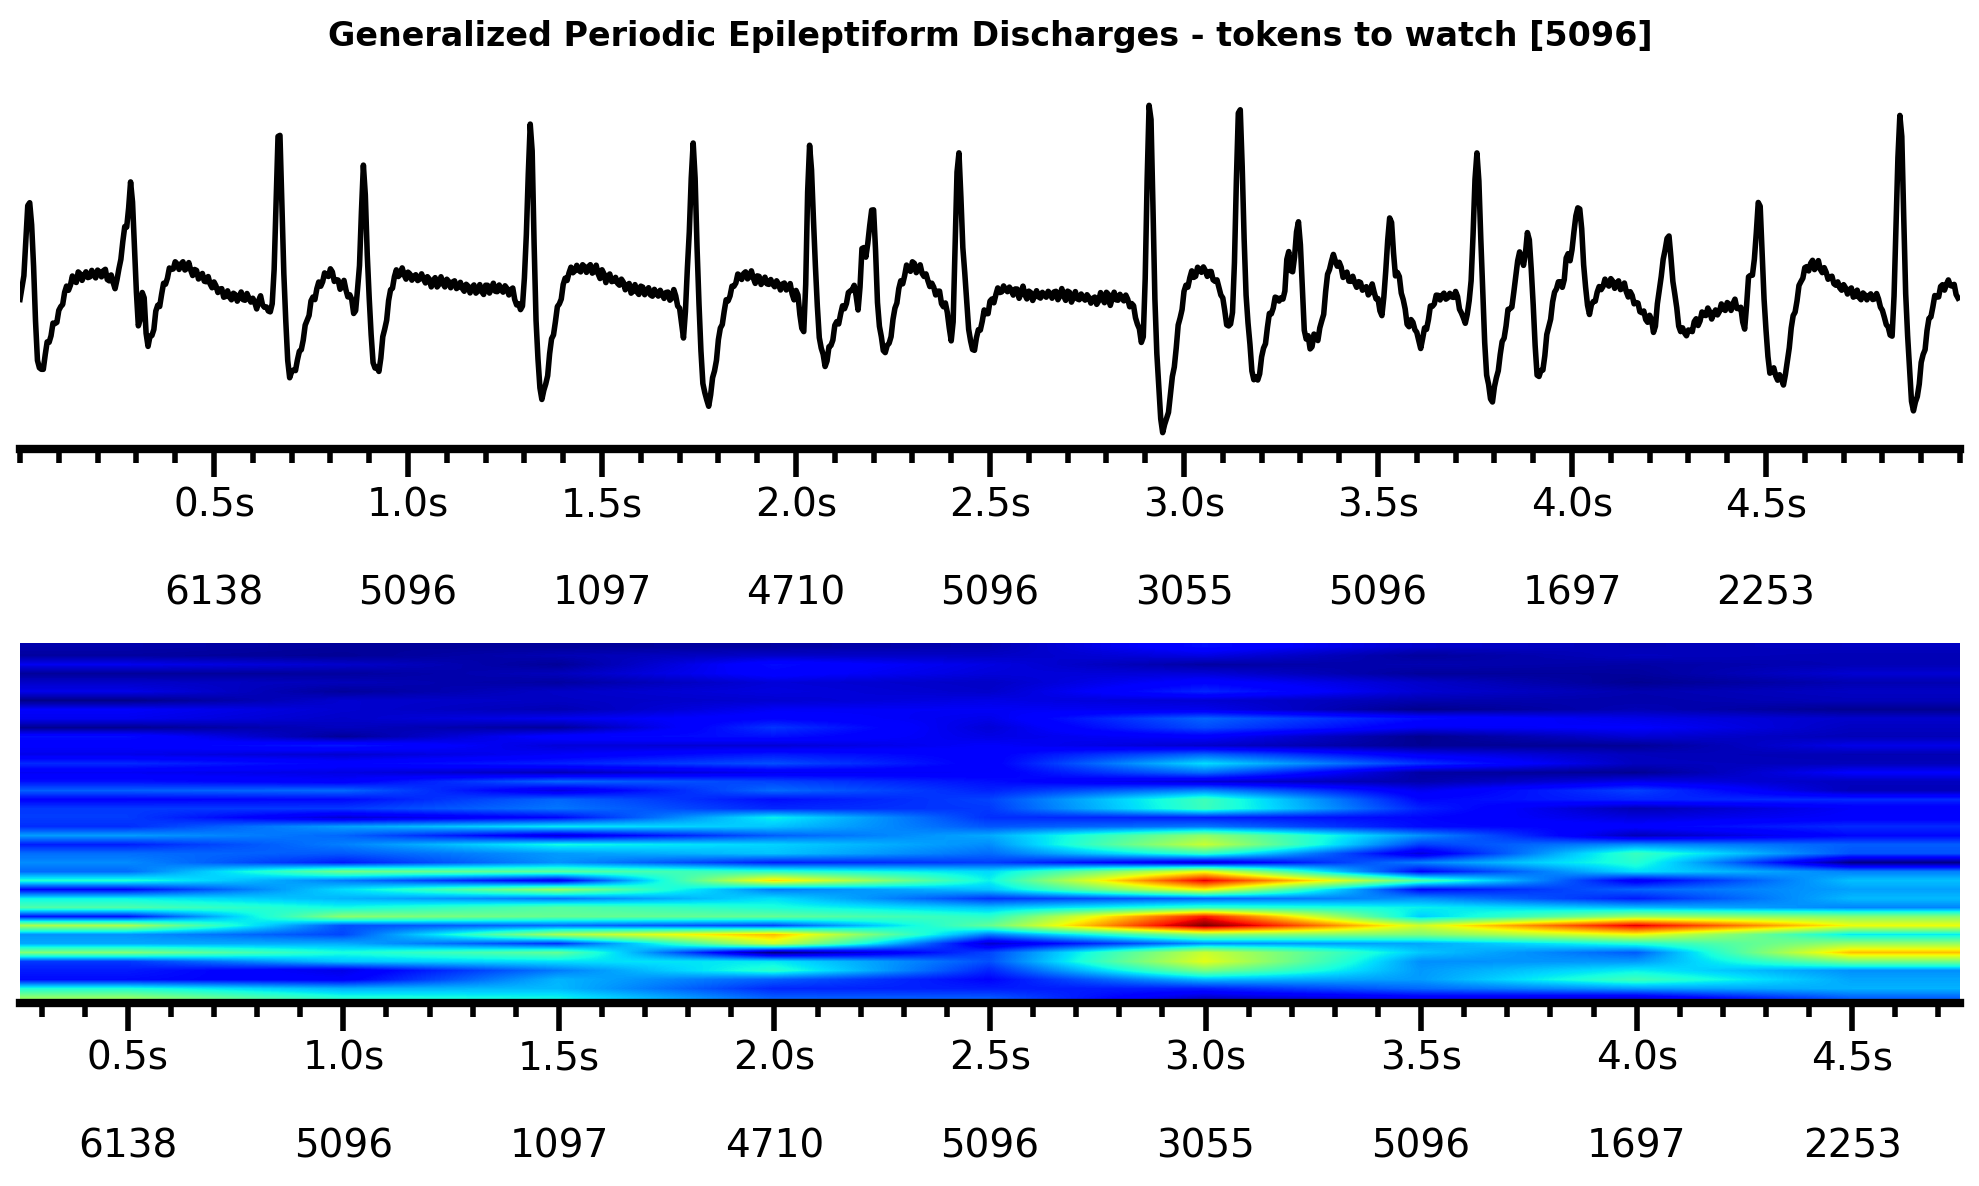

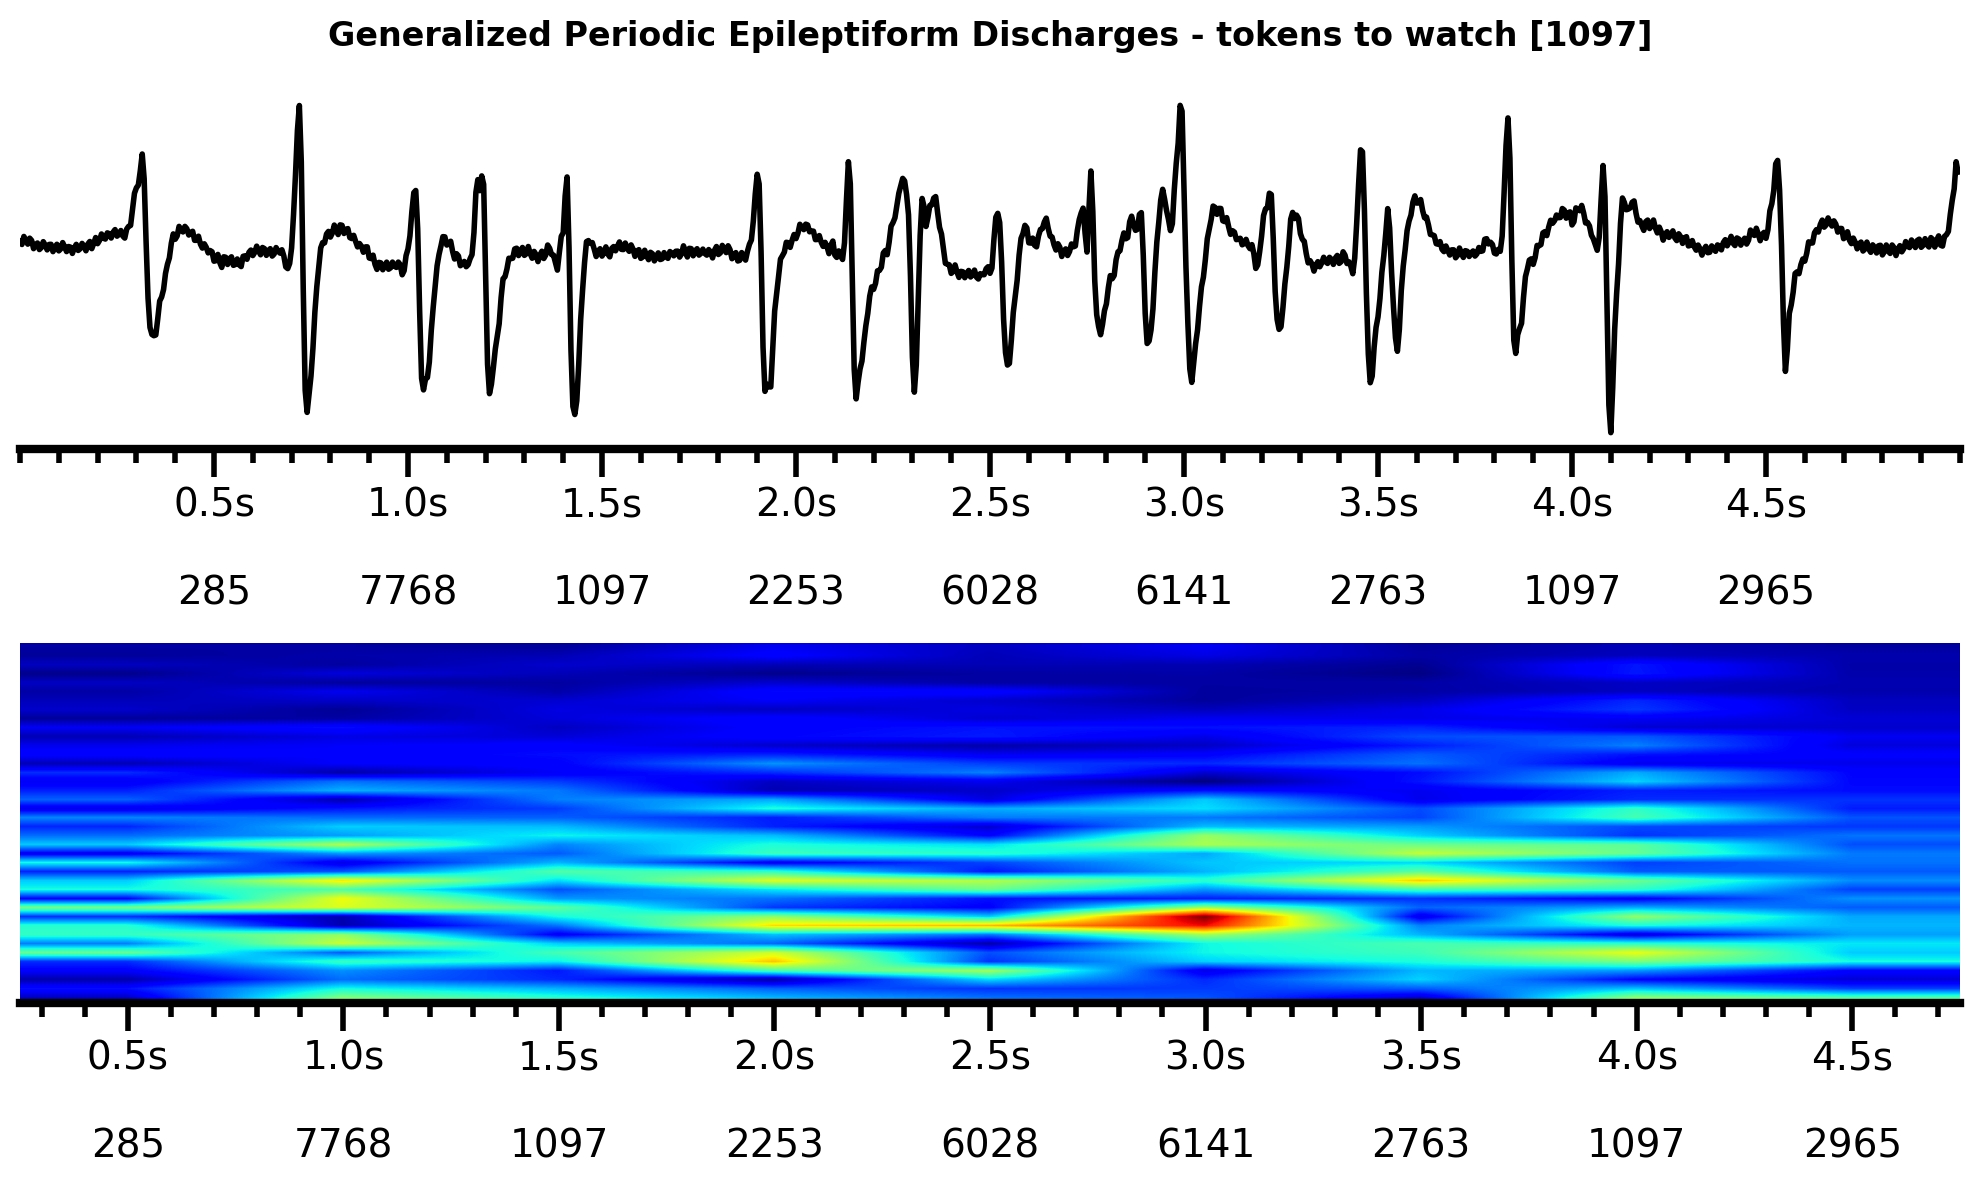

In [7]:

for sample_id in range(0,6):
    tuev_sample = pickle.load(open(f'./pretrained_weigths/TUEV_samples/TUEV_sample_{sample_id}.pkl', 'rb'))

    x = tuev_sample['signal']
    label = tuev_sample['label']
    classes = ['SPSW','GPED','PLED','EYEM','ARTF','BCKG']

    # Get STFT and rearrange the tensor
    x = torch.tensor(x).to(device)
    x = x.unsqueeze(0).unsqueeze(0)
    x_stft = get_stft_torch(x,resampling_rate=200)
    x_stft = rearrange(x_stft,'B C F T -> (B C) F T').to(x.device)
    x = rearrange(x,'B C T -> (B C) T') # here we only provide single channel EEG separately to tokenize

    with torch.no_grad():
        _,x_tokens,_ = tokenizer.tokenize(x_stft, x)
    
    # Extract data from token_array
    x_temp   = x.cpu().numpy()
    x_stft   = x_stft.cpu().numpy() 
    x_tokens = x_tokens[0].cpu().numpy()
    label    = label
    label_class = classes[label]
    intersection = tuev_sample['important_tokens']
    
    plot_token_interpret_tuev(x_temp,x_stft,x_tokens,label,intersection)